<a href="https://colab.research.google.com/github/marcelogarret/rna/blob/main/MNIST_Conv2D_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação idx2numy

In [3]:
## Instalando biblioteca para converter o Dataset MNIST Original para Numpy
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=01d0517ce1fadc3e32b9edeaeaa0c32e9633b1b08f670c85aed8092db27d87dc
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


# Importando Bibliotecas

In [4]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
import cv2

# Carregando Dataset MNIST Original

In [5]:
# Montando o Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Convertendo para Numpy o Dataset original do MNIST
# Disponível em http://yann.lecun.com/exdb/mnist/index.html

train_images = idx2numpy.convert_from_file('/content/drive/MyDrive/MNIST/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('/content/drive/MyDrive/MNIST/train-labels.idx1-ubyte')
test_images = idx2numpy.convert_from_file('/content/drive/MyDrive/MNIST/t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('/content/drive/MyDrive/MNIST/t10k-labels.idx1-ubyte')

In [7]:
# Verificando as dimensões dos vetores de dados

print(f"Train Images: {train_images.shape}")
print(f"Test Images: {test_images.shape}")

Train Images: (60000, 28, 28)
Test Images: (10000, 28, 28)


In [8]:
# Verificando os rótulos

print(f"Train Labels: {set(train_labels)}")

Train Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


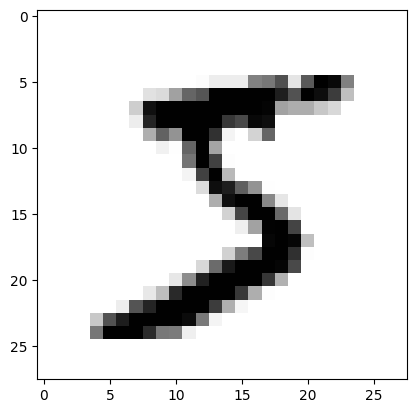

In [9]:
# Imprimindo um exemplo de imagem de treinamento

plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.show()

# Pré-processamento

In [10]:
# Criando funções para transformações de deskewing, remoção de ruído e blurring das imagens
# Deskewing: correção do alinhamento de imagens inclinadas
# Remoção de ruído: filtro de mediana para suavizar a imagem e remover pequenos ruídos
# Blurring: filtro gaussiano para suavizar ainda mais a imagem e reduzir detalhes excessivos

def deskew_image(image):
    # Calcular os momentos da imagem
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image.copy()
    # Calcular o ângulo de deskewing
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
    img = cv2.warpAffine(image, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

def remove_noise(image):
    # Aplicar um filtro de mediana para remover ruído
    return cv2.medianBlur(image, 3)

def apply_blur(image):
    # Aplicar um leve desfoque gaussiano
    return cv2.GaussianBlur(image, (3, 3), 0)

def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        img = img.astype(np.uint8)
        img = deskew_image(img)
        img = remove_noise(img)
        img = apply_blur(img)
        preprocessed_images.append(img)
    return np.array(preprocessed_images)

In [11]:
# Aplicando o pré-processamento ao dataset

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

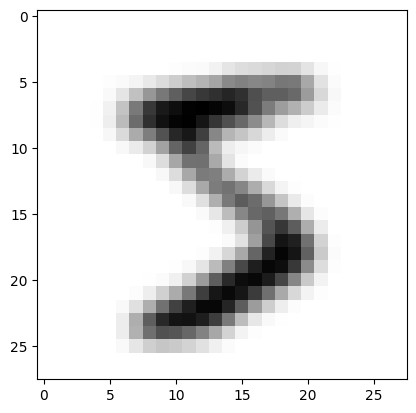

In [12]:
# Imprimindo um exemplo de imagem de treinamento após pré-processamento

plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.show()

In [13]:
# Classe para normalização dos dados

class DividePor255(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.astype("float32") / 255

# Classe de redimensionamento para 3 dimensões (altura = 28px, largura = 28px, canal = 1)
# O Keras requer uma dimensão extra no final, que corresponde aos canais.
# As imagens do MNIST são em escala de cinza, então usam apenas um canal.

class MudaShape(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.reshape((-1, 28, 28, 1))

In [14]:
# Convertendo os rótulos de números de 0 a 9 para vetores "one hot"
# Exemplo: 1 -> [0,1,0,0,0,0,0,0,0,0])

train_labels_hot = to_categorical(train_labels)
test_labels_hot = to_categorical(test_labels)

# Construção da Rede Neural CNN

In [15]:
# Definindo arquitetura da Rede Neural Convolucional (API funcional)

def define_arquitetura(input_shape, output_shape):
  inputs = keras.Input(shape=input_shape)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(output_shape, activation="softmax")(x)
  return keras.Model(inputs=inputs, outputs=outputs)

model = define_arquitetura((28,28,1), 10)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [16]:
# Definindo a Rede Neural

class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size
  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = define_arquitetura(X.shape[1:], yhot.shape[1])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self
  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

# Execução do Modelo

In [17]:
# Modelo com Pipeline de Pré-processamento + Rede Neural CNN

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", MudaShape()),
    ("ann", RedeNeural(epochs=5, batch_size=64))
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
938/938 [==============================] - 11s 5ms/step - loss: 0.1702 - accuracy: 0.9487
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0537 - accuracy: 0.9830
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0391 - accuracy: 0.9876
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0309 - accuracy: 0.9906
Epoch 5/5
313/313 [==============================] - 1s 3ms/step


0.9917